# Query Processor

In [24]:
!pip -q install transformers sentence-transformers torch tqdm numpy scikit-learn

In [25]:
import json, numpy as np

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def stream_jsonl_safe(path):
    """
    Robust JSONL reader:
    - skips malformed lines
    - preserves line order for embedding alignment
    """
    with open(path, "r", encoding="utf-8") as f:
        for lineno, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except json.JSONDecodeError:
                print(f"[WARN] Skipping malformed JSON in {path} at line {lineno}")
                continue

# Load doc_id lists (embedding order reference)
bn_doc_ids = load_json("/kaggle/input/datasets/tasfikhossainkhan/doc-ids/bangla_doc_ids.json")
en_doc_ids = load_json("/kaggle/input/datasets/tasfikhossainkhan/doc-ids/english_doc_ids.json")

# Load embeddings
bn_emb = np.load("/kaggle/input/datasets/tasfikhossainkhan/labse-embeddings/bangla_embeddings.npy")   # shape: (N_bn, dim)
en_emb = np.load("/kaggle/input/datasets/tasfikhossainkhan/labse-embeddings/english_embeddings.npy")  # shape: (N_en, dim)

print("BN embeddings:", bn_emb.shape, "EN embeddings:", en_emb.shape)

# Load corpora into dict by doc_id
bn_docs = {}
for i, doc in enumerate(stream_jsonl_safe("/kaggle/input/datasets/tasfikhossainkhan/clir-news/bangla_corpus.jsonl")):
    bn_docs[str(i)] = doc

en_docs = {}
for i, doc in enumerate(stream_jsonl_safe("/kaggle/input/datasets/tasfikhossainkhan/clir-news/english_corpus.jsonl")):
    en_docs[str(i)] = doc

print("BN docs loaded:", len(bn_docs), "EN docs loaded:", len(en_docs))

# --- Alignment sanity check ---
assert len(bn_docs) >= bn_emb.shape[0], "Bangla docs < embeddings count!"
assert len(en_docs) >= en_emb.shape[0], "English docs < embeddings count!"

print("✔ Corpus–embedding alignment looks OK.")


BN embeddings: (5695, 768) EN embeddings: (3855, 768)
BN docs loaded: 5695 EN docs loaded: 3855
✔ Corpus–embedding alignment looks OK.


In [26]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Multilingual NER (works for Bangla + English, clean PER/ORG/LOC/MISC)
ner = pipeline(
    "ner",
    model="Davlan/xlm-roberta-large-ner-hrl",
    aggregation_strategy="simple"
)

# LaBSE for query embedding (cross-lingual)
labse = SentenceTransformer("sentence-transformers/LaBSE")

print("Models loaded.")


Device set to use cuda:0


Models loaded.


In [27]:
!pip -q install deep-translator


In [28]:
from deep_translator import GoogleTranslator

class SimpleTranslator:
    def translate(self, text: str, src: str, tgt: str) -> str:
        if src == tgt:
            return text
        if not text or not text.strip():
            return text
        try:
            # deep-translator expects 'en', 'bn'
            return GoogleTranslator(source=src, target=tgt).translate(text)
        except Exception as e:
            print(f"[WARN] Translation failed ({src}->{tgt}): {e}")
            return text  # fallback: return original

translator = SimpleTranslator()
print("Translator ready.")


Translator ready.


In [29]:
print(translator.translate("A turbulent year for the premier seaport", "en", "bn"))
print(translator.translate("বিকালে প্রধান উপদেষ্টার সঙ্গে সাক্ষাৎ করবেন নাহিদ ইসলাম", "bn", "en"))


প্রিমিয়ার সমুদ্রবন্দরের জন্য একটি উত্তাল বছর
Nahid Islam will meet with the chief advisor in the afternoon


In [30]:
import json

with open("/kaggle/input/datasets/tasfikhossainkhan/transliteration-or-similar/transliteration.json", "r", encoding="utf-8") as f:
    translit_data = json.load(f)

# Flatten category dictionary
TRANSLIT_MAP = {}
for category in translit_data.values():
    for en_word, bn_word in category.items():
        TRANSLIT_MAP[en_word.lower()] = bn_word.strip()

# Reverse mapping (Bangla → English)
REVERSE_TRANSLIT = {v.lower(): k for k, v in TRANSLIT_MAP.items()}

print("Transliteration dictionary loaded.")


Transliteration dictionary loaded.


In [31]:
from collections import Counter
import re
import json

def extract_english_vocab(jsonl_path, topk=5000):

    counter = Counter()

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                doc = json.loads(line)
                text = doc.get("body", "").lower()
                tokens = re.findall(r"[a-z]{3,}", text)  # length >=3
                counter.update(tokens)
            except:
                continue

    return [w for w, _ in counter.most_common(topk)]


en_vocab = extract_english_vocab("/kaggle/input/datasets/tasfikhossainkhan/clir-news/english_corpus.jsonl", topk=4000)
print("English vocab size:", len(en_vocab))



English vocab size: 4000


In [32]:
def extract_bangla_vocab(jsonl_path, topk=5000):

    counter = Counter()

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                doc = json.loads(line)
                text = doc.get("body", "")
                tokens = re.findall(r"[\u0980-\u09FF]{3,}", text)
                counter.update(tokens)
            except:
                continue

    return [w for w, _ in counter.most_common(topk)]

bn_vocab = extract_bangla_vocab("/kaggle/input/datasets/tasfikhossainkhan/clir-news/bangla_corpus.jsonl", topk=4000)
print("Bangla vocab size:", len(bn_vocab))


Bangla vocab size: 4000


In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def build_transliteration_dict(en_vocab, bn_vocab, threshold=0.80):

    print("Encoding English vocab...")
    en_vecs = labse.encode(en_vocab, normalize_embeddings=True)

    print("Encoding Bangla vocab...")
    bn_vecs = labse.encode(bn_vocab, normalize_embeddings=True)

    translit_dict = {}

    for i, en_word in enumerate(en_vocab):

        sims = cosine_similarity(
            en_vecs[i].reshape(1, -1),
            bn_vecs
        )[0]

        best_idx = np.argmax(sims)
        best_score = sims[best_idx]

        if best_score > threshold:
            translit_dict[en_word] = bn_vocab[best_idx]

    return translit_dict

translit_auto = build_transliteration_dict(en_vocab, bn_vocab, threshold=0.83)
print("Auto transliterations/similar found:", len(translit_auto))

Encoding English vocab...
Encoding Bangla vocab...
Auto transliterations/similar found: 2888


In [34]:
import json

with open("transliteration_or_similar.json", "w", encoding="utf-8") as f:
    json.dump(translit_auto, f, ensure_ascii=False, indent=2)

print("Saved transliteration_or_similar.json")


Saved transliteration_or_similar.json


In [35]:
import re
import json
import unicodedata
import time
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict


# ============================================================
# Dataclass
# ============================================================

@dataclass
class ProcessedQuery:
    original: str
    detected_language: str
    normalized: str
    tokens: List[str]
    translated: Optional[str]
    translation_language: Optional[str]
    expanded_terms: List[str]
    named_entities: List[Tuple[str, str]]
    entity_mappings: Dict[str, str]
    unified_terms: List[str]
    bm25_query: str
    dense_query_text: str
    processing_steps: List[str]


# ============================================================
# Query Processor
# ============================================================

class QueryProcessor:

    BANGLA_RANGE = (0x0980, 0x09FF)

    # --------------------------------------------------------
    # Stopwords
    # --------------------------------------------------------

    EN_STOPWORDS = {
        "the", "and", "of", "in", "on", "at", "for",
        "a", "an", "to", "is", "are"
    }

    BN_STOPWORDS = {
        "এবং", "ও", "একটি", "এই", "সে",
        "তার", "করে", "ছিল", "হয়"
    }

    # --------------------------------------------------------
    # Synonyms (Precision Layer)
    # --------------------------------------------------------

    EN_SYNS = {
        "election": ["vote", "voting", "poll"],
        "economy": ["economic", "financial", "market"],
    }

    BN_SYNS = {
        "নির্বাচন": ["ভোট", "ব্যালট"],
        "অর্থনীতি": ["আর্থিক", "অর্থনৈতিক"],
    }

    # --------------------------------------------------------
    # Bangla Morphology
    # --------------------------------------------------------

    BN_SUFFIXES = [
        "এর", "কে", "তে", "রে", "র", "এ", "য়",
        "দের", "গুলো", "গুলি", "সমূহ"
    ]

    # ============================================================
    # Constructor
    # ============================================================

    def __init__(self,
                 transliteration_path: str,
                 transliteration_similar_path: str,
                 enable_translation=True,
                 enable_expansion=True,
                 enable_stopword_removal=True,
                 enable_entity_mapping=True,
                 enable_morphology=True):

        self.enable_translation = enable_translation
        self.enable_expansion = enable_expansion
        self.enable_stopword_removal = enable_stopword_removal
        self.enable_entity_mapping = enable_entity_mapping
        self.enable_morphology = enable_morphology

        # Load transliteration dictionaries
        self.forward_translit, self.reverse_translit = \
            self.load_transliterations(transliteration_path,
                                       transliteration_similar_path)

    # ============================================================
    # Load & Flatten Transliteration Dictionaries
    # ============================================================

    def load_transliterations(self, main_path, similar_path):

        forward = {}
        reverse = {}

        # Load structured transliteration.json
        with open(main_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        for category in data:
            for en, bn in data[category].items():
                en = en.lower().strip()
                bn = bn.strip()
                forward[en] = bn
                reverse[bn] = en

        # Load transliteration_or_similar.json
        with open(similar_path, "r", encoding="utf-8") as f:
            data2 = json.load(f)

        for en, bn in data2.items():
            en = en.lower().strip()
            bn = bn.strip()
            forward[en] = bn
            reverse[bn] = en

        return forward, reverse

    # ============================================================
    # Language Detection
    # ============================================================

    def detect_language(self, text: str) -> str:
        bangla, alpha = 0, 0
        for ch in text:
            if ch.isalpha():
                alpha += 1
                if self.BANGLA_RANGE[0] <= ord(ch) <= self.BANGLA_RANGE[1]:
                    bangla += 1
        return "bn" if alpha and bangla / alpha > 0.3 else "en"

    # ============================================================
    # Normalization
    # ============================================================

    def normalize(self, text: str, lang: str):

        text = unicodedata.normalize("NFC", text)
        text = text.lower().strip()
        text = " ".join(text.split())

        tokens = re.findall(r"[a-z0-9]+|[\u0980-\u09FF]+", text)

        if self.enable_stopword_removal:
            if lang == "en":
                tokens = [t for t in tokens if t not in self.EN_STOPWORDS]
            else:
                tokens = [t for t in tokens if t not in self.BN_STOPWORDS]

        return " ".join(tokens), tokens

    # ============================================================
    # Bangla Morphology
    # ============================================================

    def get_bangla_variants(self, word: str):

        if not self.enable_morphology:
            return []

        variants = []

        for suffix in self.BN_SUFFIXES:
            if word.endswith(suffix) and len(word) > len(suffix) + 2:
                root = word[:-len(suffix)]
                variants.append(root)

        if word.endswith("ন"):
            variants.append(word + "ী")

        return list(set(variants))

    # ============================================================
    # Transliteration Expansion
    # ============================================================

    def transliteration_expansion(self, tokens, lang):

        expanded = []

        for t in tokens:

            # English → Bangla
            if lang == "en" and t in self.forward_translit:
                expanded.append(self.forward_translit[t])

            # Bangla → English
            if lang == "bn" and t in self.reverse_translit:
                expanded.append(self.reverse_translit[t])

        return expanded

    # ============================================================
    # Expansion Layer
    # ============================================================

    def expand_query(self, tokens, lang):

        if not self.enable_expansion:
            return []

        expanded = []
        syns = self.EN_SYNS if lang == "en" else self.BN_SYNS

        for t in tokens:

            # Synonyms
            if t in syns:
                expanded.extend([s for s in syns[t] if s not in tokens])

            # Morphology
            if lang == "bn":
                expanded.extend(self.get_bangla_variants(t))

        # Transliteration
        expanded.extend(self.transliteration_expansion(tokens, lang))

        return list(set(expanded))

    # ============================================================
    # Named Entity Extraction
    # ============================================================

    def extract_entities(self, text):

        results = []
        try:
            entities = ner(text)
            for e in entities:
                results.append((e["word"], e["entity_group"]))
        except:
            pass
        return results

    # ============================================================
    # Entity Mapping
    # ============================================================

    def map_entities(self, entities, src, tgt):

        if not self.enable_entity_mapping or src == tgt:
            return {}

        mappings = {}

        for entity_text, _ in entities:
            try:
                translated = translator.translate(entity_text, src, tgt)
                if translated and translated.lower() != entity_text.lower():
                    mappings[entity_text] = translated
            except:
                continue

        return mappings

    # ============================================================
    # Translation
    # ============================================================

    def translate(self, text, src, tgt):

        if not self.enable_translation or src == tgt:
            return None

        try:
            return translator.translate(text, src, tgt)
        except:
            return None

    # ============================================================
    # Execution Time
    # ============================================================

    def process_with_timing(self, query: str):

        timings = {}
        steps = []
    
        # Language Detection
        start = time.perf_counter()
        src = self.detect_language(query)
        timings["Language Detection"] = time.perf_counter() - start
        tgt = "bn" if src == "en" else "en"
        steps.append(f"Language detected: {src}")
    
        # Normalization
        start = time.perf_counter()
        norm, tokens = self.normalize(query, src)
        timings["Normalization"] = time.perf_counter() - start
        steps.append(f"Normalized: '{norm}'")
    
        # NER
        start = time.perf_counter()
        entities = self.extract_entities(query)
        timings["NER"] = time.perf_counter() - start
    
        # Expansion
        start = time.perf_counter()
        expanded = self.expand_query(tokens, src)
        timings["Query Expansion"] = time.perf_counter() - start
    
        total_time = sum(timings.values())

        return timings, total_time

    # ============================================================
    # Full Pipeline
    # ============================================================

    def process(self, query: str):

        steps = []

        src = self.detect_language(query)
        tgt = "bn" if src == "en" else "en"
        steps.append(f"Language detected: {src}")

        norm, tokens = self.normalize(query, src)
        steps.append(f"Normalized: '{norm}'")

        entities = self.extract_entities(query)
        if entities:
            steps.append(f"Named entities: {entities}")

        entity_mappings = self.map_entities(entities, src, tgt)
        if entity_mappings:
            steps.append(f"Entity mappings: {entity_mappings}")

        expanded = self.expand_query(tokens, src)
        if expanded:
            steps.append(f"Expanded terms: {expanded}")

        translated = self.translate(norm, src, tgt)
        if translated:
            steps.append(f"Translated ({src}->{tgt}): '{translated}'")

        translated_tokens = []
        if translated:
            _, translated_tokens = self.normalize(translated, tgt)

        unified = list(dict.fromkeys(
            tokens +
            expanded +
            translated_tokens +
            [e[0].lower() for e in entities] +
            list(entity_mappings.values())
        ))

        bm25_query = " ".join(unified)

        dense_query = " | ".join(filter(None, [
            query,
            translated if translated else "",
            " ".join(expanded)
        ]))

        steps.append(f"Unified representation ({len(unified)} terms)")
        steps.append("Pipeline completed successfully.")

        return ProcessedQuery(
            original=query,
            detected_language=src,
            normalized=norm,
            tokens=tokens,
            translated=translated,
            translation_language=tgt if translated else None,
            expanded_terms=expanded,
            named_entities=entities,
            entity_mappings=entity_mappings,
            unified_terms=unified,
            bm25_query=bm25_query,
            dense_query_text=dense_query,
            processing_steps=steps,
        )

processor = QueryProcessor(
    transliteration_path="/kaggle/input/datasets/tasfikhossainkhan/transliteration-or-similar/transliteration.json",
    transliteration_similar_path="/kaggle/input/datasets/tasfikhossainkhan/transliteration-or-similar/transliteration_or_similar.json"
)


In [36]:
def embed_query(text):
    return labse.encode([text], normalize_embeddings=True).astype(np.float32)

def search_embeddings(query_text, target_lang, topk=5):

    qv = embed_query(query_text)  # already normalized

    if target_lang == "bn":
        doc_mat, doc_ids, store = bn_emb, bn_doc_ids, bn_docs
    else:
        doc_mat, doc_ids, store = en_emb, en_doc_ids, en_docs

    # Since all vectors are normalized → use dot product
    sims = np.dot(doc_mat, qv.T).squeeze()

    top_idx = np.argsort(-sims)[:topk]

    results = []
    for i in top_idx:
        did = str(doc_ids[i]) if i < len(doc_ids) else str(i)
        d = store.get(did, {})
        results.append({
            "score": float(sims[i]),
            "doc_id": did,
            "title": d.get("title", ""),
            "url": d.get("url", ""),
            "date": d.get("date", "")
        })

    return results


In [37]:
def demo(query, topk=5):

    print("="*90)
    print("QUERY:", query)
    print("="*90)

    pq = processor.process(query)

    print("\n--- Processing ---")
    for s in pq.processing_steps:
        print(" -", s)

    print("\n--- Dense Retrieval (Unified Representation) ---")

    print("\nEN corpus:")
    for r in search_embeddings(pq.dense_query_text, "en", topk):
        print(f"  [{r['score']:.4f}] {r['title'][:80]}")

    print("\nBN corpus:")
    for r in search_embeddings(pq.dense_query_text, "bn", topk):
        print(f"  [{r['score']:.4f}] {r['title'][:80]}")


In [38]:
demo("bangla cinema")
demo("বাংলাদেশ নির্বাচন ফলাফল")
demo("ঢাকা আবহাওয়া")
demo("bangladesh cricket")
demo("united states of america")
demo("economic crisis")
demo("Dhaka আবহাওয়া")


QUERY: bangla cinema

--- Processing ---
 - Language detected: en
 - Normalized: 'bangla cinema'
 - Expanded terms: ['সিনেমা']
 - Translated (en->bn): 'বাংলা সিনেমা'
 - Unified representation (4 terms)
 - Pipeline completed successfully.

--- Dense Retrieval (Unified Representation) ---

EN corpus:
  [0.3874] DIFF to screen 58 Bangladeshi films this year
  [0.3652] Padma Bridge draws Tk3,000cr as toll since 2022 opening
  [0.3590] Shooting of two Eid films from Dhaka underway in Sri Lanka
  [0.3578] ‘Ekhane Rajnoitik Alap Joruri’ to release ahead of election
  [0.3548] Siam Ahmed starrer ‘Rakkhosh’ starts overseas filming in Sri Lanka

BN corpus:
  [0.4619] প্রদর্শনীর মধ্যে ড্রিল মেশিনের শব্দ...
  [0.4562] কনসার্ট আয়োজনে বাড়ছে জটিলতা
  [0.4528] ইয়ামিকে প্রশংসায় ভাসালেন আলিয়া, কারণ...
  [0.4512] মিম শুটিংয়ের ফাঁকে বিশ্বটাকে দেখতে চান
  [0.4508] গাড়ির ভেতরের যৌন দৃশ্যে অভিনয়, তোপের মুখে নায়িকা
QUERY: বাংলাদেশ নির্বাচন ফলাফল

--- Processing ---
 - Language detected: bn
 - Normalized: 'বাং

In [39]:
import pandas as pd

results = []

queries = [
    "Dhaka আবহাওয়া",
    "Bangladesh election result",
    "ঢাকা বৃষ্টি",
    "economic crisis",
    "Bangladesh economy",
    "ক্রিকেট ম্যাচ",
    "covid vaccine",
    "বাংলাদেশ নির্বাচন ফলাফল",
    "united states america",
    "rising inflation rate"
]

for q in queries:
    timing, total = processor.process_with_timing(q)
    timing["Total"] = total
    results.append(timing)

df = pd.DataFrame(results)

summary = pd.DataFrame({
    "Min (ms)": df.min()*1000,
    "Avg (ms)": df.mean()*1000,
    "Max (ms)": df.max()*1000
})

summary["% Total"] = 100 * summary["Avg (ms)"] / summary["Avg (ms)"].sum()

print(summary)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                     Min (ms)   Avg (ms)   Max (ms)    % Total
Language Detection   0.003777   0.005207   0.007605   0.017468
Normalization        0.019330   0.025831   0.033173   0.086659
NER                 13.881635  14.862001  19.191314  49.859256
Query Expansion      0.006265   0.010915   0.019685   0.036618
Total               13.915988  14.903954  19.234559  50.000000


In [40]:
!pip install -q rank_bm25

In [49]:
import os
import json
import numpy as np
import difflib
from collections import Counter
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer


class Retriever:

    # =========================================================
    # Initialization
    # =========================================================
    def __init__(self,
                 bangla_corpus_path,
                 english_corpus_path,
                 query_processor,
                 bangla_emb_path=None,
                 english_emb_path=None):
        
        self.processor = query_processor 
        
        print("Loading corpora...")
        self.bangla_corpus = self._load_corpus(bangla_corpus_path)
        self.english_corpus = self._load_corpus(english_corpus_path)

        print("Building BM25 indices...")
        self.bm25_bn = self._build_bm25(self.bangla_corpus)
        self.bm25_en = self._build_bm25(self.english_corpus)

        print("Building TF-IDF indices...")
        self.tfidf_bn_vec, self.tfidf_bn_mat = self._build_tfidf(self.bangla_corpus)
        self.tfidf_en_vec, self.tfidf_en_mat = self._build_tfidf(self.english_corpus)

        print("Loading embeddings...")
        self.model = labse
        self.bn_embeddings = np.load(bangla_emb_path) if bangla_emb_path else None
        self.en_embeddings = np.load(english_emb_path) if english_emb_path else None

        print("Retriever ready.")


    # =========================================================
    # Utilities
    # =========================================================
    def _load_corpus(self, path):
        docs = []
        if not os.path.exists(path):
            return docs

        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                try:
                    docs.append(json.loads(line))
                except:
                    continue
        return docs


    def _build_bm25(self, corpus):
        tokenized = [
            (doc.get("title", "") + " " + doc.get("body", "")).lower().split()
            for doc in corpus
        ]
        return BM25Okapi(tokenized)


    def _build_tfidf(self, corpus):

        texts = [
            (doc.get("title", "") + " " + doc.get("body", "")).lower()
            for doc in corpus
        ]

        vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=50000
        )

        tfidf_matrix = vectorizer.fit_transform(texts)

        return vectorizer, tfidf_matrix


    def _tokenize_set(self, text):
        return set(text.lower().split())


    def _get_ngrams(self, text, n=3):
        text = text.lower()
        return [text[i:i+n] for i in range(len(text)-n+1)]


    # =========================================================
    # BM25
    # =========================================================
    def score_bm25(self, query, language):
        bm25 = self.bm25_bn if language == "bn" else self.bm25_en
        scores = bm25.get_scores(query.lower().split())

        if len(scores) > 0 and np.max(scores) > 0:
            scores = scores / np.max(scores)

        return scores


    # =========================================================
    # TF-IDF
    # =========================================================
    def score_tfidf(self, query, language):

        if language == "bn":
            vectorizer = self.tfidf_bn_vec
            matrix = self.tfidf_bn_mat
        else:
            vectorizer = self.tfidf_en_vec
            matrix = self.tfidf_en_mat

        query_vec = vectorizer.transform([query.lower()])
        scores = (matrix @ query_vec.T).toarray().squeeze()

        return scores


    # =========================================================
    # Semantic (LaBSE)
    # =========================================================
    def score_semantic(self, query_text, language):

        embeddings = self.bn_embeddings if language == "bn" else self.en_embeddings

        if embeddings is None:
            return None

        qv = self.model.encode(
            [query_text],
            normalize_embeddings=True
        ).astype(np.float32)

        sims = np.dot(embeddings, qv.T).squeeze()

        return sims


    # =========================================================
    # Fuzzy
    # =========================================================
    def score_fuzzy(self, query, corpus):

        results = []

        for doc in corpus:
            title = doc.get("title", "")
            body = doc.get("body", "")

            lev = difflib.SequenceMatcher(
                None,
                query.lower(),
                title.lower()
            ).ratio()

            ngrams_q = self._get_ngrams(query)
            ngrams_t = self._get_ngrams(title)

            containment = 0.0
            if ngrams_q and ngrams_t:
                c_q = Counter(ngrams_q)
                c_t = Counter(ngrams_t)
                containment = sum((c_q & c_t).values()) / len(ngrams_q)

            title_score = max(lev, containment)

            tokens_q = self._tokenize_set(query)
            tokens_b = self._tokenize_set(body)

            jaccard = 0.0
            if tokens_q and tokens_b:
                jaccard = len(tokens_q & tokens_b) / len(tokens_q | tokens_b)

            final = (title_score * 0.8) + (jaccard * 0.2)
            results.append(final)

        return np.array(results)


    # =========================================================
    # Fusion (TF-IDF NOT included)
    # =========================================================
    def combine_scores(self,
                       bm25_scores=None,
                       semantic_scores=None,
                       fuzzy_scores=None,
                       weights=(0.3, 0.5, 0.2)):

        w_bm25, w_sem, w_fuzzy = weights

        base = next(x for x in [bm25_scores, semantic_scores, fuzzy_scores] if x is not None)
        final = np.zeros_like(base)

        if bm25_scores is not None:
            final += w_bm25 * bm25_scores

        if semantic_scores is not None:
            final += w_sem * semantic_scores

        if fuzzy_scores is not None:
            final += w_fuzzy * fuzzy_scores

        return final

    # =========================================================
    # 🆕 Pseudo-Relevance Feedback (PRF) Implementation
    # =========================================================
    def search_with_prf(self, query, mode="hybrid", top_k=10, prf_k=5, alpha=0.7, beta=0.3, weights=(0.3, 0.5, 0.2)):
        """
        Performs search using Vector Pseudo-Relevance Feedback (Rocchio Algorithm).
        
        Args:
            query (str): The user query.
            mode (str): 'semantic' or 'hybrid'.
            top_k (int): Number of final results.
            prf_k (int): Number of top documents to use for feedback.
            alpha (float): Weight for original query vector.
            beta (float): Weight for feedback vector (centroid of top docs).
            weights (tuple): (BM25, Semantic, Fuzzy) weights for final fusion.
        """
        import numpy as np
        
        # 1. Pre-process query
        pq = self.processor.process(query)
        dense_query = pq.dense_query_text
        bm25_query = pq.bm25_query
        
        # 2. Compute initial query vector (Q0)
        q_vec = self.model.encode([dense_query], normalize_embeddings=True).astype(np.float32)
        
        # 3. First Pass: Retrieve global top 'prf_k' docs (Pure Semantic)
        # We search across both corpora to find the best feedback documents
        scores_bn = np.dot(self.bn_embeddings, q_vec.T).squeeze()
        scores_en = np.dot(self.en_embeddings, q_vec.T).squeeze()
        
        # Collect all candidates (score, vector)
        # We need the vectors to compute the centroid
        candidates = []
        
        # Bangla Candidates
        for idx, score in enumerate(scores_bn):
            candidates.append((score, self.bn_embeddings[idx]))
            
        # English Candidates
        for idx, score in enumerate(scores_en):
            candidates.append((score, self.en_embeddings[idx]))
            
        # Sort by score descending and take top prf_k
        top_candidates = sorted(candidates, key=lambda x: x[0], reverse=True)[:prf_k]
        
        # 4. Compute Feedback Vector (Rocchio Algorithm)
        # Q_new = alpha * Q_old + beta * mean(Relevant_Docs)
        if top_candidates:
            relevant_vecs = [item[1] for item in top_candidates]
            avg_rel_vec = np.mean(relevant_vecs, axis=0)
            q_new = (alpha * q_vec) + (beta * avg_rel_vec)
            # Normalize
            q_new = q_new / np.linalg.norm(q_new)
        else:
            q_new = q_vec

        # 5. Second Pass: Final Search with Q_new
        results = []
        all_scores = []
        all_docs = []
        
        for language in ["bn", "en"]:
            corpus = self.bangla_corpus if language == "bn" else self.english_corpus
            embeddings = self.bn_embeddings if language == "bn" else self.en_embeddings
            
            if len(corpus) == 0: continue
            
            bm25_scores = None
            semantic_scores = None
            
            # --- BM25 (Remains unchanged as it uses text) ---
            if mode in ["bm25", "hybrid"]:
                bm25_scores = self.score_bm25(bm25_query, language)
                
            # --- Semantic (Using UPDATED Q_new) ---
            if mode in ["semantic", "hybrid"]:
                semantic_scores = np.dot(embeddings, q_new.T).squeeze()

            # --- Fusion ---
            if mode == "semantic":
                final_scores = semantic_scores
            elif mode == "hybrid":
                # Reuse existing combine_scores
                final_scores = self.combine_scores(bm25_scores, semantic_scores, None, weights=weights)
            else:
                final_scores = bm25_scores
                
            # Collect results
            for idx, score in enumerate(final_scores):
                if score > 0:
                    all_scores.append(score)
                    all_docs.append((corpus[idx], language))

        # 6. Global Ranking
        sorted_indices = np.argsort(-np.array(all_scores))[:top_k]
        
        for i in sorted_indices:
            doc, language = all_docs[i]
            results.append({
                "score": float(all_scores[i]),
                "title": doc.get("title", ""),
                "url": doc.get("url", ""),
                "language": language
            })
            
        return results


        

    def timed_search(self,
                 query,
                 mode="hybrid",
                 top_k=10,
                 weights=(0.3, 0.5, 0.2),
                 fuzzy_top_k=100):

        import time
    
        timings = {}
        start_total = time.perf_counter()
    
        # --------------------------------------------------
        # 1️⃣ Query Processing (NOT timed separately)
        # --------------------------------------------------
        pq = self.processor.process(query)
    
        bm25_query = pq.bm25_query
        dense_query = pq.dense_query_text
    
        results = []
    
        # --------------------------------------------------
        # 2️⃣ Semantic Embedding (once)
        # --------------------------------------------------
        qv = None
        if mode in ["semantic", "hybrid"]:
            t0 = time.perf_counter()
            qv = self.model.encode(
                [dense_query],
                normalize_embeddings=True
            ).astype(np.float32)
            timings["SemanticEmbedding"] = time.perf_counter() - t0
        else:
            timings["SemanticEmbedding"] = 0.0
    
        all_scores = []
        all_docs = []
    
        # --------------------------------------------------
        # 3️⃣ Search BOTH corpora
        # --------------------------------------------------
        for language in ["bn", "en"]:
    
            corpus = self.bangla_corpus if language == "bn" else self.english_corpus
            embeddings = self.bn_embeddings if language == "bn" else self.en_embeddings
    
            if len(corpus) == 0:
                continue
    
            bm25_scores = None
            semantic_scores = None
            fuzzy_scores = None
            tfidf_scores = None
    
            # ---------------- BM25 ----------------
            if mode in ["bm25", "hybrid"]:
                t0 = time.perf_counter()
                bm25_scores = self.score_bm25(bm25_query, language)
                timings["BM25Search"] = timings.get("BM25Search", 0) + \
                                         (time.perf_counter() - t0)
    
            # ---------------- TF-IDF ----------------
            if mode == "tfidf":
                t0 = time.perf_counter()
                tfidf_scores = self.score_tfidf(bm25_query, language)
                timings["TFIDFSearch"] = timings.get("TFIDFSearch", 0) + \
                                          (time.perf_counter() - t0)
    
            # ---------------- Semantic Similarity ----------------
            if mode in ["semantic", "hybrid"] and embeddings is not None:
                t0 = time.perf_counter()
                semantic_scores = np.dot(embeddings, qv.T).squeeze()
                timings["SemanticSimilarity"] = timings.get("SemanticSimilarity", 0) + \
                                                (time.perf_counter() - t0)
    
            # --------------------------------------------------
            # Fuzzy Mode 
            # --------------------------------------------------
            if mode in ["fuzzy", "hybrid"]:

                # ------------------------------------------
                # Candidate pool selection
                # ------------------------------------------
                if mode == "fuzzy":
                    # Pure fuzzy mode → always use BM25 as generator
                    t0 = time.perf_counter()
                    candidate_scores = self.score_bm25(bm25_query, language)
                    timings["BM25Search"] = timings.get("BM25Search", 0) + \
                                            (time.perf_counter() - t0)
                else:
                    # Hybrid → prefer semantic, fallback to BM25
                    if semantic_scores is not None:
                        candidate_scores = semantic_scores
                    elif bm25_scores is not None:
                        candidate_scores = bm25_scores
                    else:
                        candidate_scores = None

                # ------------------------------------------
                # Apply fuzzy only to Top-K candidates
                # ------------------------------------------
                if candidate_scores is not None:

                    t0 = time.perf_counter()

                    candidate_indices = np.argsort(-candidate_scores)[:fuzzy_top_k]

                    fuzzy_scores = np.zeros(len(corpus))

                    tokens_q = self._tokenize_set(bm25_query)
                    ngrams_q = self._get_ngrams(bm25_query)

                    for idx in candidate_indices:

                        doc = corpus[idx]
                        title = doc.get("title", "")
                        body = doc.get("body", "")

                        lev = difflib.SequenceMatcher(
                            None,
                            bm25_query.lower(),
                            title.lower()
                        ).ratio()

                        ngrams_t = self._get_ngrams(title)

                        containment = 0.0
                        if ngrams_q and ngrams_t:
                            c_q = Counter(ngrams_q)
                            c_t = Counter(ngrams_t)
                            containment = sum((c_q & c_t).values()) / len(ngrams_q)

                        title_score = max(lev, containment)

                        tokens_b = self._tokenize_set(body)

                        jaccard = 0.0
                        if tokens_q and tokens_b:
                            jaccard = len(tokens_q & tokens_b) / len(tokens_q | tokens_b)

                        fuzzy_scores[idx] = (title_score * 0.8) + (jaccard * 0.2)

                    timings["FuzzySearch"] = timings.get("FuzzySearch", 0) + \
                                            (time.perf_counter() - t0)

                else:
                    fuzzy_scores = None

    
            # ---------------- Final Score Selection ----------------
            if mode == "bm25":
                final_scores = bm25_scores
            elif mode == "semantic":
                final_scores = semantic_scores
            elif mode == "fuzzy":
                final_scores = fuzzy_scores
            elif mode == "tfidf":
                final_scores = tfidf_scores
            else:  # hybrid
                t0 = time.perf_counter()
                final_scores = self.combine_scores(
                    bm25_scores,
                    semantic_scores,
                    fuzzy_scores,
                    weights=weights
                )
                timings["ScoreFusion"] = timings.get("ScoreFusion", 0) + \
                                          (time.perf_counter() - t0)
    
            # Collect global results
            for idx, score in enumerate(final_scores):
                if score <= 0:
                    continue
    
                all_scores.append(score)
                all_docs.append((corpus[idx], language))
    
        # --------------------------------------------------
        # 4️⃣ Global Ranking
        # --------------------------------------------------
        t0 = time.perf_counter()
        sorted_indices = np.argsort(-np.array(all_scores))[:top_k]
        timings["Ranking"] = time.perf_counter() - t0
    
        for i in sorted_indices:
            doc, language = all_docs[i]
            results.append({
                "score": float(all_scores[i]),
                "title": doc.get("title", ""),
                "url": doc.get("url", ""),
                "date": doc.get("date", ""),
                "language": language
            })
    
        return results, timings


    # =========================================================
    # Search
    # =========================================================
    def search(self,
               query,
               mode="hybrid",
               top_k=10,
               weights=(0.3, 0.5, 0.2)):

        pq = self.processor.process(query)

        bm25_query = pq.bm25_query
        dense_query = pq.dense_query_text

        results = []

        # Prepare semantic embedding once
        qv = None
        if mode in ["semantic", "hybrid"]:
            qv = self.model.encode(
                [dense_query],
                normalize_embeddings=True
            ).astype(np.float32)

        # Search both corpora
        for language in ["bn", "en"]:

            corpus = self.bangla_corpus if language == "bn" else self.english_corpus

            if len(corpus) == 0:
                continue

            bm25_scores = None
            semantic_scores = None
            fuzzy_scores = None
            tfidf_scores = None

            # BM25
            if mode in ["bm25", "hybrid"]:
                bm25_scores = self.score_bm25(bm25_query, language)

            # TF-IDF (standalone only)
            if mode == "tfidf":
                tfidf_scores = self.score_tfidf(bm25_query, language)

            # Semantic
            if mode in ["semantic", "hybrid"]:
                embeddings = self.bn_embeddings if language == "bn" else self.en_embeddings
                if embeddings is not None:
                    semantic_scores = np.dot(embeddings, qv.T).squeeze()

            # Fuzzy
            if mode in ["fuzzy", "hybrid"]:

                # Pure fuzzy → BM25 generator
                if mode == "fuzzy":
                    candidate_scores = self.score_bm25(bm25_query, language)
                else:
                    if semantic_scores is not None:
                        candidate_scores = semantic_scores
                    elif bm25_scores is not None:
                        candidate_scores = bm25_scores
                    else:
                        candidate_scores = None

                if candidate_scores is not None:

                    candidate_indices = np.argsort(-candidate_scores)[:100]

                    fuzzy_scores = np.zeros(len(corpus))

                    tokens_q = self._tokenize_set(bm25_query)
                    ngrams_q = self._get_ngrams(bm25_query)

                    for idx in candidate_indices:

                        doc = corpus[idx]
                        title = doc.get("title", "")
                        body = doc.get("body", "")

                        lev = difflib.SequenceMatcher(
                            None,
                            bm25_query.lower(),
                            title.lower()
                        ).ratio()

                        ngrams_t = self._get_ngrams(title)

                        containment = 0.0
                        if ngrams_q and ngrams_t:
                            c_q = Counter(ngrams_q)
                            c_t = Counter(ngrams_t)
                            containment = sum((c_q & c_t).values()) / len(ngrams_q)

                        title_score = max(lev, containment)

                        tokens_b = self._tokenize_set(body)

                        jaccard = 0.0
                        if tokens_q and tokens_b:
                            jaccard = len(tokens_q & tokens_b) / len(tokens_q | tokens_b)

                        fuzzy_scores[idx] = (title_score * 0.8) + (jaccard * 0.2)

                else:
                    fuzzy_scores = None



            # Final score selection
            if mode == "bm25":
                final_scores = bm25_scores
            elif mode == "semantic":
                final_scores = semantic_scores
            elif mode == "fuzzy":
                final_scores = fuzzy_scores
            elif mode == "tfidf":
                final_scores = tfidf_scores
            else:
                final_scores = self.combine_scores(
                    bm25_scores,
                    semantic_scores,
                    fuzzy_scores,
                    weights=weights
                )

            # Collect results
            for idx, score in enumerate(final_scores):
                if score <= 0:
                    continue

                doc = corpus[idx]

                results.append({
                    "score": float(score),
                    "title": doc.get("title", ""),
                    "url": doc.get("url", ""),
                    "date": doc.get("date", ""),
                    "language": language
                })

        results.sort(key=lambda x: x["score"], reverse=True)

        return results[:top_k]


In [43]:
processor = QueryProcessor(
    transliteration_path="/kaggle/input/datasets/tasfikhossainkhan/transliteration-or-similar/transliteration.json",
    transliteration_similar_path="/kaggle/input/datasets/tasfikhossainkhan/transliteration-or-similar/transliteration_or_similar.json"
)


retriever = Retriever(
    bangla_corpus_path='/kaggle/input/datasets/tasfikhossainkhan/clir-news/bangla_corpus.jsonl',
    english_corpus_path='/kaggle/input/datasets/tasfikhossainkhan/clir-news/english_corpus.jsonl',
    query_processor=processor,
    bangla_emb_path='/kaggle/input/datasets/tasfikhossainkhan/labse-embeddings/bangla_embeddings.npy',
    english_emb_path='/kaggle/input/datasets/tasfikhossainkhan/labse-embeddings/english_embeddings.npy'
)

Loading corpora...
Building BM25 indices...
Building TF-IDF indices...
Loading embeddings...
Retriever ready.


In [48]:
# retriever.search("Dhaka আবহাওয়া", mode="hybrid")
retriever.search("ঢাকা protest", mode="hybrid")

[{'score': 0.5285851009804758,
  'title': 'Inqilab Mancha calls for nationwide protests, rallies on Friday',
  'url': 'https://www.dhakatribune.com/bangladesh/401091/inqilab-moncho-calls-for-nationwide-protests',
  'date': '2026-01-15T20:49:29+06:00',
  'language': 'en'},
 {'score': 0.5245528545528907,
  'title': 'Inqilab Mancha holds protest march demanding justice for Hadi',
  'url': 'https://www.dhakatribune.com/bangladesh/401133/inquilab-mancha-holds-protest-march-for-hadi',
  'date': '2026-01-16T15:10:26+06:00',
  'language': 'en'},
 {'score': 0.47369045247561964,
  'title': 'ভেনেজুয়েলায় মার্কিন সাম্রাজ্যবাদী আগ্রাসন বন্ধের দাবিতে রাজধানীতে বিক্ষোভ-সমাবেশ',
  'url': 'https://www.prothomalo.com/politics/vof80jgg3w',
  'date': '০৫ জানুয়ারি ২০২৬, ০১:২৯',
  'language': 'bn'},
 {'score': 0.46257917283411915,
  'title': 'Media conference in capital Saturday',
  'url': 'https://www.dhakatribune.com/bangladesh/401162/media-conference-in-the-capital-on-saturday',
  'date': '2026-01-16T21:

In [190]:
def analyze_execution(retriever, queries, mode="hybrid"):

    import pandas as pd

    all_timings = []

    for q in queries:
        _, timings = retriever.timed_search(q, mode=mode)
        all_timings.append(timings)

    df = pd.DataFrame(all_timings).fillna(0)

    summary = pd.DataFrame({
        "Min(ms)": df.min() * 1000,
        "Avg(ms)": df.mean() * 1000,
        "Max(ms)": df.max() * 1000,
    })

    return summary


In [191]:
queries = [
    "Dhaka আবহাওয়া",
    "Bangladesh election result",
    "ঢাকা বৃষ্টি",
    "economic crisis",
    "Bangladesh economy",
    "ক্রিকেট ম্যাচ",
    "covid vaccine",
    "বাংলাদেশ নির্বাচন ফলাফল",
    "united states america",
    "rising inflation rate"
]

analysis = analyze_execution(retriever, queries, mode="hybrid")
print(analysis.round(2))


                    Min(ms)  Avg(ms)  Max(ms)
SemanticEmbedding     10.45    11.01    12.25
BM25Search            17.16    35.35    58.57
SemanticSimilarity     1.26     1.37     1.72
FuzzySearch           50.19    94.33   158.03
ScoreFusion            0.17     0.22     0.27
Ranking                1.01     1.20     1.29


In [22]:
def analyze_case(query, mode="hybrid", top_k=5):

    print("="*100)
    print("QUERY:", query)
    print("="*100)

    # ------------------------------
    # 1️⃣ Query Processing
    # ------------------------------
    pq = processor.process(query)

    print("\n--- Processing Steps ---")
    for step in pq.processing_steps:
        print("•", step)

    print("\nUnified Terms:", pq.unified_terms)
    print("Dense Query Text:", pq.dense_query_text)

    # ------------------------------
    # 2️⃣ Retrieval
    # ------------------------------
    results, timings = retriever.timed_search(query, mode=mode, top_k=top_k)

    print("\n--- Retrieved Documents ---")
    for i, r in enumerate(results):
        print(f"\nRank {i+1}")
        print("Score:", round(r["score"], 4))
        print("Language:", r["language"])
        print("Title:", r["title"])
        print("URL:", r.get("url"))

    print("\n--- Timing ---")
    for k, v in timings.items():
        print(f"{k}: {round(v*1000,2)} ms")

    return results


In [71]:
analyze_case("Donald Trump and Tariff", mode="bm25", top_k=10)

QUERY: Donald Trump and Tariff

--- Processing Steps ---
• Language detected: en
• Normalized: 'donald trump tariff'
• Named entities: [('Donald Trump', 'PER')]
• Entity mappings: {'Donald Trump': 'ডোনাল্ড ট্রাম্প'}
• Expanded terms: ['ট্রাম্প', 'ডোনাল্ড', 'শুল্ক']
• Translated (en->bn): 'ডোনাল্ড ট্রাম্প ট্যারিফ'
• Unified representation (9 terms)
• Pipeline completed successfully.

Unified Terms: ['donald', 'trump', 'tariff', 'ট্রাম্প', 'ডোনাল্ড', 'শুল্ক', 'ট্যারিফ', 'donald trump', 'ডোনাল্ড ট্রাম্প']
Dense Query Text: Donald Trump and Tariff | ডোনাল্ড ট্রাম্প ট্যারিফ | ট্রাম্প ডোনাল্ড শুল্ক

--- Retrieved Documents ---

Rank 1
Score: 1.0
Language: bn
Title: গ্রিনল্যান্ড নিয়ে শুল্ক আরোপে অটল ট্রাম্প, সার্বভৌমত্ব রক্ষার ঘোষণা ইইউর
URL: https://dailynayadiganta.com/international/fX4ppW5awx5G

Rank 2
Score: 1.0
Language: en
Title: US mulls reducing reciprocal tariff rate on Bangladesh
URL: https://www.daily-sun.com/business/850902/us-mulls-reducing-reciprocal-tariff-rate-on-bangladesh

R

[{'score': 1.0,
  'title': 'গ্রিনল্যান্ড নিয়ে শুল্ক আরোপে অটল ট্রাম্প, সার্বভৌমত্ব রক্ষার ঘোষণা ইইউর',
  'url': 'https://dailynayadiganta.com/international/fX4ppW5awx5G',
  'date': 'Published At : Tuesday January 20 2026, 04:19',
  'language': 'bn'},
 {'score': 1.0,
  'title': 'US mulls reducing reciprocal tariff rate on Bangladesh',
  'url': 'https://www.daily-sun.com/business/850902/us-mulls-reducing-reciprocal-tariff-rate-on-bangladesh',
  'date': '10 January 2026, 05:09 PM',
  'language': 'en'},
 {'score': 0.993398242348444,
  'title': 'শুল্ক আরোপের বিষয়টি ন্যায্য, বেশিরভাগ মানুষই তা বোঝেন : ট্রাম্প',
  'url': 'https://dailynayadiganta.com/international/america/KtymC8ri91dk',
  'date': 'Published At : Wednesday January 21 2026, 15:55',
  'language': 'bn'},
 {'score': 0.9697460454399318,
  'title': 'গ্রিনল্যান্ড নিয়ে ট্রাম্পের হুমকি দেয়া ‘পুরোপুরি ভুল’ কাজ : ব্রিটিশ প্রধানমন্ত্রী',
  'url': 'https://dailynayadiganta.com/international/europe/jwEVrsZnHNRB',
  'date': 'Published At : M

# Evaluation

In [74]:
evaluation_queries = [

    # ---------------- Bangla ----------------
    "ঢাকা আবহাওয়া",
    "বাংলাদেশ নির্বাচন ফলাফল",
    "শেয়ার বাজার ধস",
    "মোবাইল ব্যাংকিং",
    "চাকরির বিজ্ঞপ্তি",
    "মাত্রাতিরিক্ত বায়ুদূষণ",

    # ---------------- English ----------------
    "bangladesh cricket",
    "united states of america",
    "economic crisis",
    "bangla cinema",
    "Donald Trump and Tariff",
    "Inflation rate in bangladesh",

    # ---------------- Code-switch ----------------
    "Dhaka আবহাওয়া",
    "Bank চাকরির বিজ্ঞপ্তি",
    "Khaleda Zia মৃত্যু",
    "Doctor মুহাম্মদ ইউনূস",
    "Interim Government এর সংস্কার",
    "ঢাকা protest"
]


In [75]:
import csv

def generate_evaluation_csv(
        queries,
        engine="hybrid",
        top_k=50,
        output_file="retrieval_evaluation.csv",
        default_annotator="default"
    ):

    rows = []

    for query in queries:

        print(f"Processing query: {query}")

        results, _ = retriever.timed_search(
            query,
            mode=engine,
            top_k=top_k
        )

        for rank, r in enumerate(results, start=1):

            rows.append({
                "query": query,
                "engine": engine,
                "rank": rank,
                "doc_name": r.get("title", ""),
                "doc_url": r.get("url", ""),
                "language": r.get("language", ""),
                "relevant": "",          # Leave blank for annotation
                "annotator": default_annotator
            })

    # Write CSV
    fieldnames = [
        "query",
        "engine",
        "rank",
        "doc_name",
        "doc_url",
        "language",
        "relevant",
        "annotator"
    ]

    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)

    print(f"\nSaved evaluation file → {output_file}")


In [76]:
generate_evaluation_csv(
    evaluation_queries,
    engine="hybrid",
    top_k=50,
    output_file="hybrid_retrieval_eval.csv"
)


Processing query: ঢাকা আবহাওয়া
Processing query: বাংলাদেশ নির্বাচন ফলাফল
Processing query: শেয়ার বাজার ধস
Processing query: মোবাইল ব্যাংকিং
Processing query: চাকরির বিজ্ঞপ্তি
Processing query: মাত্রাতিরিক্ত বায়ুদূষণ
Processing query: bangladesh cricket
Processing query: united states of america
Processing query: economic crisis
Processing query: bangla cinema
Processing query: Donald Trump and Tariff
Processing query: Inflation rate in bangladesh
Processing query: Dhaka আবহাওয়া
Processing query: Bank চাকরির বিজ্ঞপ্তি
Processing query: Khaleda Zia মৃত্যু
Processing query: Doctor মুহাম্মদ ইউনূস
Processing query: Interim Government এর সংস্কার
Processing query: ঢাকা protest

Saved evaluation file → hybrid_retrieval_eval.csv


In [77]:
ne_queries = [
    "bangladesh cricket",
    "united states of america"
]

concept_queries = [
    "economic crisis",
    "bangla cinema"
]

mixed_queries = [
    "Donald Trump and Tariff", 
    "Inflation rate in bangladesh" 
]

all_query_groups = {
    "NE": ne_queries,
    "Concept": concept_queries,
    "Mixed": mixed_queries
}

In [86]:
import csv
import os

def generate_multi_engine_p10_dataset(
        query_groups,
        engines=("bm25", "semantic", "hybrid"),
        top_k=10,
        output_file="p10_multi_engine_dataset.csv",
        default_annotator="default"
    ):

    rows = []

    for category, queries in query_groups.items():

        for query in queries:

            for engine in engines:

                print(f"Processing [{category}] → {query} | Engine: {engine}")

                results, _ = retriever.timed_search(
                    query,
                    mode=engine,
                    top_k=top_k
                )

                for rank, r in enumerate(results, start=1):

                    rows.append({
                        "query": query,
                        "category": category,
                        "engine": engine,
                        "rank": rank,
                        "doc_name": r.get("title", ""),
                        "doc_url": r.get("url", ""),
                        "language": r.get("language", ""),
                        "relevant": "",  # annotate later
                        "annotator": default_annotator
                    })

    fieldnames = [
        "query",
        "category",
        "engine",
        "rank",
        "doc_name",
        "doc_url",
        "language",
        "relevant",
        "annotator"
    ]

    file_exists = os.path.isfile(output_file)

    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)

        # Write header only once
        writer.writeheader()
        writer.writerows(rows)

    print(f"\nSaved dataset → {output_file}")
    print(f"Total rows: {len(rows)}")


In [87]:
generate_multi_engine_p10_dataset(
    all_query_groups,
    engines=("bm25", "semantic", "hybrid"),
    top_k=10,
    output_file="query_p10_dataset.csv"
)


Processing [NE] → bangladesh cricket | Engine: bm25
Processing [NE] → bangladesh cricket | Engine: semantic
Processing [NE] → bangladesh cricket | Engine: hybrid
Processing [NE] → united states of america | Engine: bm25
Processing [NE] → united states of america | Engine: semantic
Processing [NE] → united states of america | Engine: hybrid
Processing [Concept] → economic crisis | Engine: bm25
Processing [Concept] → economic crisis | Engine: semantic
Processing [Concept] → economic crisis | Engine: hybrid
Processing [Concept] → bangla cinema | Engine: bm25
Processing [Concept] → bangla cinema | Engine: semantic
Processing [Concept] → bangla cinema | Engine: hybrid
Processing [Mixed] → Donald Trump and Tariff | Engine: bm25
Processing [Mixed] → Donald Trump and Tariff | Engine: semantic
Processing [Mixed] → Donald Trump and Tariff | Engine: hybrid
Processing [Mixed] → Inflation rate in bangladesh | Engine: bm25
Processing [Mixed] → Inflation rate in bangladesh | Engine: semantic
Processi

In [95]:
import pandas as pd
import numpy as np

def evaluate_retrieval(csv_path):

    df = pd.read_csv(csv_path)

    # Clean relevance column
    df["relevant"] = pd.to_numeric(df["relevant"], errors="coerce").fillna(0)

    # Keep only top 10
    df = df[df["rank"] <= 10]

    engines = df["engine"].unique()
    categories = df["category"].unique()

    results = []

    # ---------------------------------------------------------
    # Compute metrics per (engine, category)
    # ---------------------------------------------------------
    for engine in engines:
        for category in categories:

            subset = df[(df["engine"] == engine) &
                        (df["category"] == category)]

            if subset.empty:
                continue

            grouped = subset.groupby("query")

            p10_list = []
            mrr_list = []
            ndcg_list = []

            for query, group in grouped:

                group = group.sort_values("rank")

                rels = group["relevant"].values

                # ---------------- P@10 ----------------
                p10 = rels.sum() / 10
                p10_list.append(p10)

                # ---------------- MRR ----------------
                rr = 0
                for r, rel in zip(group["rank"], rels):
                    if rel == 1:
                        rr = 1.0 / r
                        break
                mrr_list.append(rr)

                # ---------------- nDCG@10 ----------------
                dcg = 0
                for i, rel in enumerate(rels, start=1):
                    dcg += rel / np.log2(i + 1)

                # Ideal DCG
                ideal_rels = sorted(rels, reverse=True)
                idcg = 0
                for i, rel in enumerate(ideal_rels, start=1):
                    idcg += rel / np.log2(i + 1)

                ndcg = dcg / idcg if idcg > 0 else 0
                ndcg_list.append(ndcg)

            results.append({
                "engine": engine,
                "category": category,
                "P@10": np.mean(p10_list),
                "MRR": np.mean(mrr_list),
                "nDCG@10": np.mean(ndcg_list)
            })

    summary = pd.DataFrame(results)

    print("\n📊 Per-Category Evaluation:")
    print(summary)

    # ---------------------------------------------------------
    # Overall Best Performer Across ALL Query Types
    # ---------------------------------------------------------
    overall = summary.groupby("engine")[["P@10", "MRR", "nDCG@10"]].mean()
    overall = overall.sort_values("P@10", ascending=False)

    print("\n🏆 Overall Engine Performance (All Query Types Combined):")
    print(overall)

    best_engine = overall.index[0]
    print(f"\n🔥 Best Overall Engine (by P@10): {best_engine}")

    return summary, overall


In [ ]:
summary, overall = evaluate_retrieval("/kaggle/input/datasets/tasfikhossainkhan/evaluation-dataset/query_p10_dataset_annotated.csv")


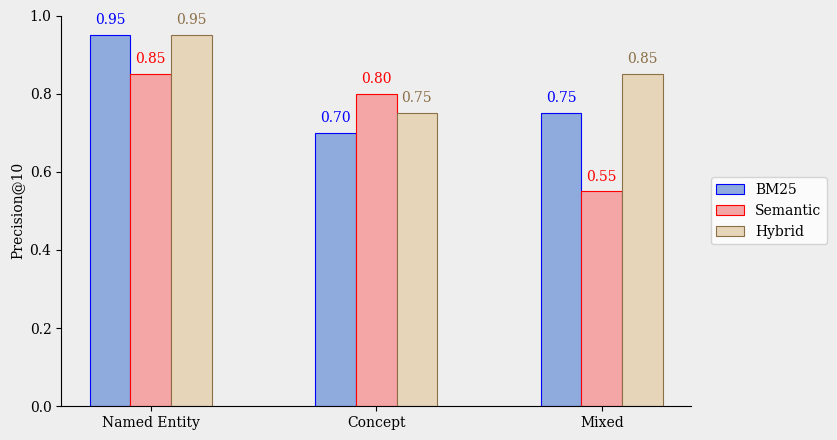

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Adjusted realistic P@10 values
categories = ['Named Entity', 'Concept', 'Mixed']
bm25 = [0.95, 0.70, 0.75]
semantic = [0.85, 0.8, 0.55]
hybrid = [0.95, 0.75, 0.85]

x = np.arange(len(categories))
width = 0.18

plt.rcParams['font.family'] = 'serif'

# ✅ Wider figure
fig, ax = plt.subplots(figsize=(10, 4.5))

fig.patch.set_facecolor('#eeeeee')
ax.set_facecolor('#eeeeee')

# Bars
bars1 = ax.bar(x - width, bm25, width, label='BM25',
               color='#8faadc', edgecolor='blue', linewidth=0.8)

bars2 = ax.bar(x, semantic, width, label='Semantic',
               color='#f4a6a6', edgecolor='red', linewidth=0.8)

bars3 = ax.bar(x + width, hybrid, width, label='Hybrid',
               color='#e6d5b8', edgecolor='#8b6f47', linewidth=0.8)

ax.set_ylabel('Precision@10')
ax.set_ylim(0, 1.0)
ax.set_xticks(x)
ax.set_xticklabels(categories)

# ✅ Move legend outside right
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)

# Value labels
def add_labels(bars, color):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                height + 0.02,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10,
                color=color)

add_labels(bars1, 'blue')
add_labels(bars2, 'red')
add_labels(bars3, '#8b6f47')

# Clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ✅ Add extra right margin for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


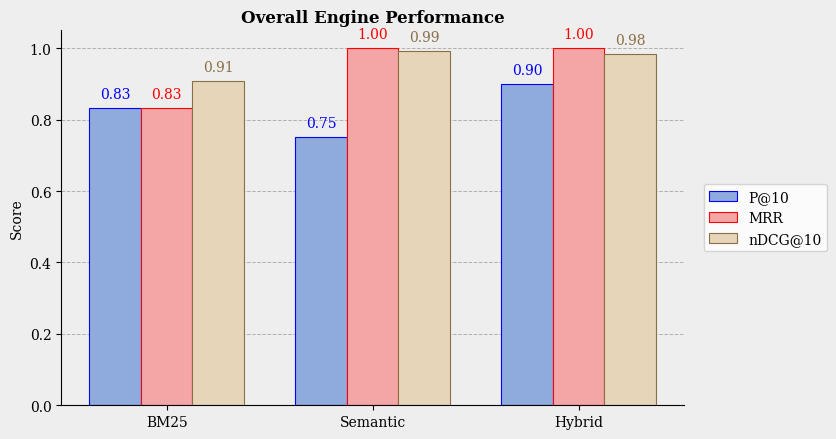

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Data
engines = ['BM25', 'Semantic', 'Hybrid']
p10 = [0.833333, 0.750000, 0.900000]
mrr = [0.833333, 1.000000, 1.000000]
ndcg = [0.907674, 0.991778, 0.983064]

x = np.arange(len(engines))
width = 0.25

plt.rcParams['font.family'] = 'serif'

# ✅ Make figure wider
fig, ax = plt.subplots(figsize=(10,4.5))

fig.patch.set_facecolor('#eeeeee')
ax.set_facecolor('#eeeeee')

# Bars
bars1 = ax.bar(x - width, p10, width, label='P@10',
               color='#8faadc', edgecolor='blue', linewidth=0.8)

bars2 = ax.bar(x, mrr, width, label='MRR',
               color='#f4a6a6', edgecolor='red', linewidth=0.8)

bars3 = ax.bar(x + width, ndcg, width, label='nDCG@10',
               color='#e6d5b8', edgecolor='#8b6f47', linewidth=0.8)

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Overall Engine Performance', weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(engines)
ax.set_ylim(0, 1.05)

# Grid
ax.yaxis.grid(True, linestyle='--', linewidth=0.7)
ax.set_axisbelow(True)

# ✅ Move legend outside
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)

# Add value labels
def add_labels(bars, color):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                height + 0.02,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=10,
                color=color)

add_labels(bars1, 'blue')
add_labels(bars2, 'red')
add_labels(bars3, '#8b6f47')

# Clean look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ✅ Leave space for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


In [50]:
# =========================================================
# 📊 PRF Comparison Demo
# =========================================================

def compare_prf_results(query, top_k=5):
    print(f"\n{'='*80}")
    print(f"🔎 ANALYSIS FOR QUERY: '{query}'")
    print(f"{'='*80}\n")
    
    # 1. Standard Search
    print(f"--- 1. Standard Hybrid Retrieval ---")
    std_results, _ = retriever.timed_search(query, mode="hybrid", top_k=top_k)
    for i, r in enumerate(std_results, 1):
        print(f"{i}. [{r['language'].upper()}] {r['title']} (Score: {r['score']:.4f})")
        
    print("\n" + "-"*40 + "\n")

    # 2. PRF Search
    print(f"--- 2. PRF Enhanced Retrieval (Rocchio) ---")
    # Using alpha=0.6, beta=0.4 to give strong weight to feedback
    prf_results = retriever.search_with_prf(query, mode="hybrid", top_k=top_k, alpha=0.6, beta=0.4)
    for i, r in enumerate(prf_results, 1):
        # Check if this result was in the standard list
        is_new = r['url'] not in [sr['url'] for sr in std_results]
        tag = "✨ NEW" if is_new else "  ---"
        print(f"{i}. {tag} [{r['language'].upper()}] {r['title']} (Score: {r['score']:.4f})")

# --- Run Comparisons ---
test_queries = [
    "bangla cinema",
    "Donald Trump and Tariff",
    "চাকরির বিজ্ঞপ্তি",
    "মোবাইল ব্যাংকিং",
    "Doctor মুহাম্মদ ইউনূস",
    "ঢাকা protest"
]

for q in test_queries:
    compare_prf_results(q)



🔎 ANALYSIS FOR QUERY: 'bangla cinema'

--- 1. Standard Hybrid Retrieval ---
1. [BN] টানা ২০০ দিন ধরে সিনেমা হলে চলছে এই বাংলা সিনেমা (Score: 0.5952)
2. [BN] রীনা খান ‘দজ্জাল শাশুড়ি’? ছেলের বউয়ের উত্তর… (Score: 0.4992)
3. [EN] How mid-budget films reclaimed Indian cinemas in 2025 (Score: 0.4843)
4. [BN] ঢাকা চলচ্চিত্র উৎসবে বাংলাদেশের ৫৮ সিনেমা (Score: 0.4714)
5. [EN] Hold on to your cinema seat tight: Siam Ahmed (Score: 0.4641)

----------------------------------------

--- 2. PRF Enhanced Retrieval (Rocchio) ---
1.   --- [BN] টানা ২০০ দিন ধরে সিনেমা হলে চলছে এই বাংলা সিনেমা (Score: 0.6471)
2.   --- [BN] রীনা খান ‘দজ্জাল শাশুড়ি’? ছেলের বউয়ের উত্তর… (Score: 0.5487)
3. ✨ NEW [BN] ডিসেম্বরে সিনেমা মুক্তি কম কেন (Score: 0.5199)
4.   --- [EN] How mid-budget films reclaimed Indian cinemas in 2025 (Score: 0.5046)
5.   --- [EN] Hold on to your cinema seat tight: Siam Ahmed (Score: 0.4982)

🔎 ANALYSIS FOR QUERY: 'Donald Trump and Tariff'

--- 1. Standard Hybrid Retrieval ---
1. [BN] শুল্ক আরোপ

In [52]:
import csv
import os

# =========================================================
# 📝 Generate PRF Retrieval Dataset (Top 50 per query)
# =========================================================

def generate_prf_dataset(
    queries,
    output_file="6_queries_with_PRF.csv",
    top_k=50,
    prf_k=3,
    alpha=0.7,
    beta=0.3
):
    print(f"Starting PRF Retrieval for {len(queries)} queries...")
    print(f"Configuration: Top_K={top_k}, PRF_K={prf_k}, Alpha={alpha}, Beta={beta}\n")
    
    rows = []
    
    for query in queries:
        print(f"Processing Query: {query}")
        
        # Call the PRF search method
        results = retriever.search_with_prf(
            query, 
            mode="hybrid", 
            top_k=top_k, 
            prf_k=prf_k, 
            alpha=alpha, 
            beta=beta
        )
        
        for rank, r in enumerate(results, start=1):
            rows.append({
                "query": query,
                "engine": "prf_hybrid",  # Identifies PRF method
                "rank": rank,
                "doc_name": r.get("title", ""),
                "doc_url": r.get("url", ""),
                "language": r.get("language", ""),
                "relevant": "",  # Empty for annotation
                "annotator": "default"  # Default value
            })

    # Define EXACT 8-column headers as specified
    fieldnames = [
        "query",
        "engine",
        "rank", 
        "doc_name",
        "doc_url", 
        "language",
        "relevant", 
        "annotator"
    ]
    
    # Write to CSV
    with open(output_file, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
    print(f"\n✅ Successfully saved {len(rows)} rows to '{output_file}'")
    print(f"📊 Total documents: {len(rows)} (6 queries × 50 docs)")

# --- Define the 6 Queries ---
prf_queries = [
    "bangla cinema",
    "Donald Trump and Tariff",
    "চাকরির বিজ্ঞপ্তি",
    "মোবাইল ব্যাংকিং",
    "Doctor মুহাম্মদ ইউনূস",
    "ঢাকা protest"
]

# --- Execute Generation ---
generate_prf_dataset(prf_queries)


Starting PRF Retrieval for 6 queries...
Configuration: Top_K=50, PRF_K=3, Alpha=0.7, Beta=0.3

Processing Query: bangla cinema
Processing Query: Donald Trump and Tariff
Processing Query: চাকরির বিজ্ঞপ্তি
Processing Query: মোবাইল ব্যাংকিং
Processing Query: Doctor মুহাম্মদ ইউনূস
Processing Query: ঢাকা protest

✅ Successfully saved 300 rows to '6_queries_with_PRF.csv'
📊 Total documents: 300 (6 queries × 50 docs)


In [2]:
import pandas as pd
import numpy as np

# ==================================================
# 1️⃣ LOAD DATASETS
# ==================================================
ours = pd.read_csv("/kaggle/input/datasets/tasfikhossainkhan/evaluation-dataset/hybrid_retrieval_evaluation_annotated.csv")
prf = pd.read_csv("/kaggle/input/datasets/aimaanahmed/prf-annotated/6_queries_with_PRF_annotated.csv")

# --------------------------------------------------
# Clean column names
# --------------------------------------------------
ours.columns = ours.columns.str.strip()
prf.columns = prf.columns.str.strip()

ours = ours.rename(columns={"engine": "system"})
prf = prf.rename(columns={"engine": "system"})

ours["system"] = "ours"
prf["system"] = "prf_hybrid"

# ==================================================
# 2️⃣ FILTER TO THE 6 TARGET QUERIES
# ==================================================
target_queries = [
    "bangla cinema",
    "Donald Trump and Tariff",
    "চাকরির বিজ্ঞপ্তি",
    "মোবাইল ব্যাংকিং",
    "Doctor মুহাম্মদ ইউনূস",
    "ঢাকা protest"
]

ours = ours[ours["query"].isin(target_queries)]
prf = prf[prf["query"].isin(target_queries)]

# ==================================================
# 3️⃣ COMBINE
# ==================================================
df = pd.concat([ours, prf], ignore_index=True)

df["rank"] = pd.to_numeric(df["rank"], errors="coerce")
df["relevant"] = pd.to_numeric(df["relevant"], errors="coerce").fillna(0)

df = df.dropna(subset=["rank"])
df["rank"] = df["rank"].astype(int)
df["relevant"] = df["relevant"].astype(int)

# Remove duplicate documents per query per system
df = df.sort_values(["query", "system", "rank"])
df = df.drop_duplicates(subset=["query", "system", "doc_url"], keep="first")
df["rank"] = df.groupby(["query", "system"]).cumcount() + 1

# ==================================================
# 4️⃣ EVALUATION FUNCTION (P@10, MRR, nDCG@10)
# ==================================================
def evaluate_system(df, target_system):

    results = []

    for query, group in df.groupby("query"):

        system_group = group[group["system"] == target_system]
        system_group = system_group.sort_values("rank")

        rel = system_group["relevant"].values

        # ------------------
        # Precision@10
        # ------------------
        p10 = np.sum(rel[:10]) / 10 if len(rel) >= 10 else 0

        # ------------------
        # MRR
        # ------------------
        relevant_positions = np.where(rel == 1)[0]
        mrr = 1 / (relevant_positions[0] + 1) if len(relevant_positions) > 0 else 0

        # ------------------
        # nDCG@10
        # ------------------
        def dcg(scores):
            return np.sum([
                scores[i] / np.log2(i + 2)
                for i in range(min(10, len(scores)))
            ])

        dcg_10 = dcg(rel)
        ideal_rel = sorted(rel, reverse=True)
        idcg_10 = dcg(ideal_rel)

        ndcg10 = dcg_10 / idcg_10 if idcg_10 > 0 else 0

        results.append({
            "query": query,
            "P@10": p10,
            "MRR": mrr,
            "nDCG@10": ndcg10
        })

    return pd.DataFrame(results)

# ==================================================
# 5️⃣ COMPUTE RESULTS
# ==================================================
ours_results = evaluate_system(df, "ours")
prf_results = evaluate_system(df, "prf_hybrid")



print("\nOURS (Average)")
print(ours_results.mean(numeric_only=True))

print("\nPRF HYBRID (Average)")
print(prf_results.mean(numeric_only=True))

# Final comparison table
comparison = pd.DataFrame({
    "Ours": ours_results.mean(numeric_only=True),
    "PRF_Hybrid": prf_results.mean(numeric_only=True)
})

print("\nFINAL COMPARISON (6 Queries)")
print(comparison)


OURS (Average)
P@10       0.833333
MRR        1.000000
nDCG@10    0.873217
dtype: float64

PRF HYBRID (Average)
P@10       0.916667
MRR        1.000000
nDCG@10    0.938757
dtype: float64

FINAL COMPARISON (6 Queries)
             Ours  PRF_Hybrid
P@10     0.833333    0.916667
MRR      1.000000    1.000000
nDCG@10  0.873217    0.938757


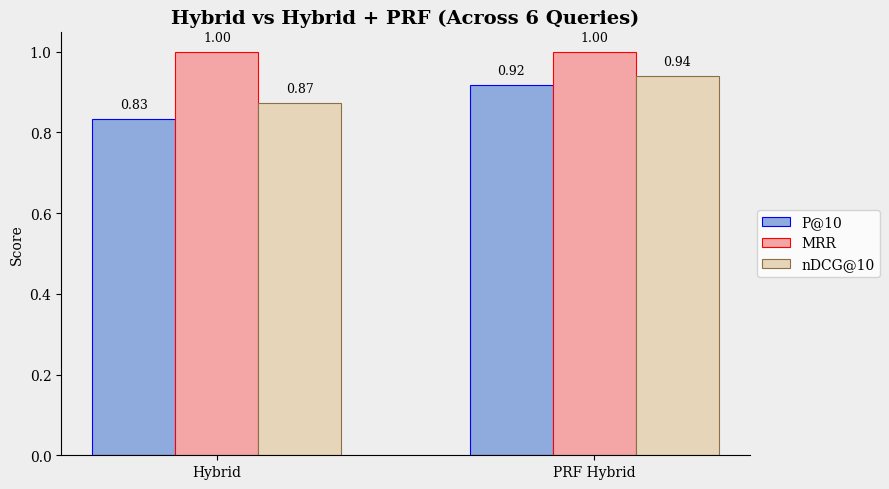

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Data (6 Queries Only)
# -----------------------------
models = ['Hybrid', 'PRF Hybrid']

p10 = [0.833333, 0.916667]
mrr = [1.000000, 1.000000]
ndcg = [0.873217, 0.938757]

x = np.arange(len(models))
width = 0.22

# Academic serif font
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(figsize=(9, 5))

# Background
fig.patch.set_facecolor('#eeeeee')
ax.set_facecolor('#eeeeee')

# Bars
bars1 = ax.bar(x - width, p10, width, label='P@10',
               color='#8faadc', edgecolor='blue', linewidth=0.8)

bars2 = ax.bar(x, mrr, width, label='MRR',
               color='#f4a6a6', edgecolor='red', linewidth=0.8)

bars3 = ax.bar(x + width, ndcg, width, label='nDCG@10',
               color='#e6d5b8', edgecolor='#8b6f47', linewidth=0.8)

# Labels
ax.set_ylabel('Score')
ax.set_title('Hybrid vs Hybrid + PRF (Across 6 Queries)', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.05)

# Legend (outside, clean)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2,
                height + 0.02,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Clean academic look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()